参考：
1. https://tensorflow.google.cn/probability/examples/Probabilistic_Layers_Regression
2. https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb

## 回归模型中的不确定性

### 用到的库与函数

In [19]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from keras.utils.vis_utils import plot_model
import ssl
ssl._create_default_https_context = ssl._create_unverified_context # 解决 [SSL: CERTIFICATE_VERIFY_FAILED] 问题
sns.set_theme(style="whitegrid")

tfd = tfp.distributions
tfb = tfp.bijectors


### 似然函数

我们可以使用 tensorflow_probability 模块来指定一种概率模型，而后最小化其负$log$似然函数(negative log-likelihood)

In [20]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

### 训练数据点

数据点，取自 $ y = f(x) + \epsilon (x)$, 其中$\epsilon (x)$ 为与$x$相关点随机误差，$f$中含有权重和偏置$w_0, b_0 = 0.125, 5.$

In [21]:
#@title Synthesize dataset.
w0, b0 = 0.125, 5.
x_range = [-20, 60] # x范围

def load_dataset(n=150, n_tst=150): # 150个训练点，150个测试点
  np.random.seed(43) # 随机数种子
  def s(x): 
    g = (x - x_range[0]) / (x_range[1] - x_range[0]) # 归一化处理
    return 3 * (0.25 + g**2.)
  # 训练集(x,y)
  x = np.random.uniform(x_range[0],x_range[1],n) #产生 n 个 x_range[0]到x_range[1] 之间的随机数
  eps = np.random.randn(n) * s(x) # 误差，与x相关
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps 
  x = x[..., np.newaxis] #使得 1*n维 变成 n*1维
  # 验证集
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32) #验证集
  eps_tst = np.random.randn(n_tst) * s(x_tst) # 误差，与x相关
  y_tst = (w0 * x_tst * (1. + np.sin(x_tst)) + b0) + eps_tst
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst,y_tst

y, x, x_tst,y_tst = load_dataset()

tra_data = {'x':x.flatten(),'y':y,'set':'observed'} # 转成dataframe格式 便于绘图
tra_data = pd.DataFrame(tra_data) 
print(tra_data)

val_data = (x_tst,y_tst)


             x         y       set
0   -10.795635  1.982906  observed
1    28.725323  8.924187  observed
2    -9.328723  2.955338  observed
3    -0.752830  4.901770  observed
4     6.171124  6.323897  observed
..         ...       ...       ...
145 -14.389125  5.275462  observed
146  20.672075  9.285062  observed
147   6.548139  5.736720  observed
148  -2.840174  3.747891  observed
149 -12.427448  3.871031  observed

[150 rows x 3 columns]


### Case 1: 无不确定度

训练模型，希望模型参数能够接近 $w_0, b_0 = 0.125, 5.$ 

In [22]:
# Build model. 
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1), #一层dense模型
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)), #输出层服从正态分布，mean=t,std=1
])

# Do inference. #编译和训练， loss为似然函数，使用(x,y)点集训练
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False)

#打印出模型权重 前面设定训练点为 w0, b0 = 0.125, 5.
[print(np.squeeze(w.numpy())) for w in model.weights]
yhat = model(x_tst) # 预测, 输出为一正则分布分布
assert isinstance(yhat, tfd.Distribution) #判断 yhat 是否为 tfd.Distribution 类型

0.13444557878610677
5.126196885306532


绘制训练点 (x,y) 分布和预测点 (x_tst,yhat) 的平均值曲线

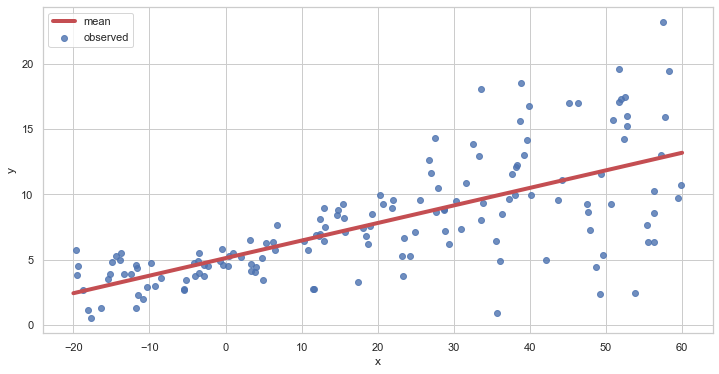

In [23]:
#@title Figure 1: No uncertainty. 到数第二层，即dense层，模型参数，权重和偏置
w = np.squeeze(model.layers[-2].kernel.numpy())
b = np.squeeze(model.layers[-2].bias.numpy())

plt.figure(figsize=(12, 6))

plt.plot(x_tst,yhat.mean(),'r', label='mean', linewidth=4); # --- 绘制预测点平均值

sns.regplot(x='x',y='y',data=tra_data,label='observed',fit_reg=False)# 绘制训练点
plt.legend()
plt.savefig('./fig/fig1.png')

### Case 2: Aleatoric Uncertainty

随机不确定性可分为常数部分和与输入$\hat x$相关部分。其跟数据本身有关，其来源于传感器噪声、测量误差等等情况，增加训练数据并不能减少这部分不确定性。

In [24]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1 + 1), # 输出变为两维 共有4个参数
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1], #后一维拟合期望，前一维拟合方差
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))), # softplus 函数 log(1+e^x)
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[0.1227492  0.96091328]
[5.20118307 6.14829492]


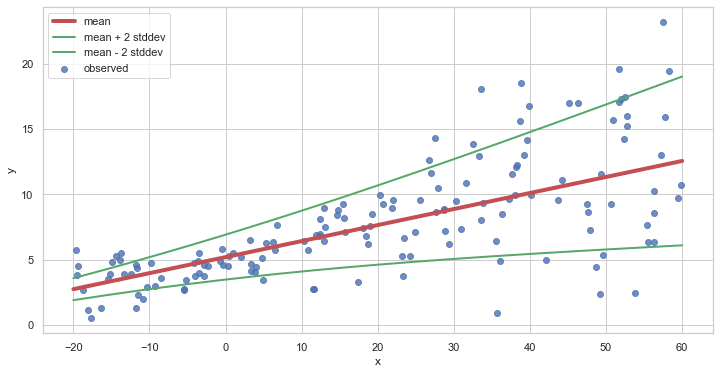

In [25]:
#@title Figure 2: Aleatoric Uncertainty
m = yhat.mean()
s = yhat.stddev()

plt.figure(figsize=(12, 6))

plt.plot(x_tst, m, 'r', linewidth=4, label='mean');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev')
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev')

sns.regplot(x='x',y='y',data=tra_data,label='observed',fit_reg=False)# 绘制训练点
plt.legend()
plt.savefig('./fig/fig2.png')

### Case 3: Epistemic Uncertainty

主要来源于模型本身，例如模型参数做微小扰动产生的不确定性

In [26]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
# 作为后验分布，输入参数为 w,b 的 size，返回值需为 tfd.Distribution 类型
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.)) # 常数 log(e-1)
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In [27]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
# 作为先验分布，输入参数为 w,b 的 size，返回值需为 tfd.Distribution 类型
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1), # mean=t,std=1
          reinterpreted_batch_ndims=1)),
  ])

In [28]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=0.01)), # 输出层方差固定为0.01,此时没考虑Aleatoric Uncertainty
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.build((1,1))
plot_model(model,to_file='./fig/model3.pdf',show_shapes=True,show_layer_names=False) # 绘制模型结构
model.fit(x, y, epochs=1000, verbose=False);

# Profit. # weight,bias,posterior,prior
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 0.12869364  5.12163103 -4.07729897 -2.41356755]
[0.12755377 5.15395381]


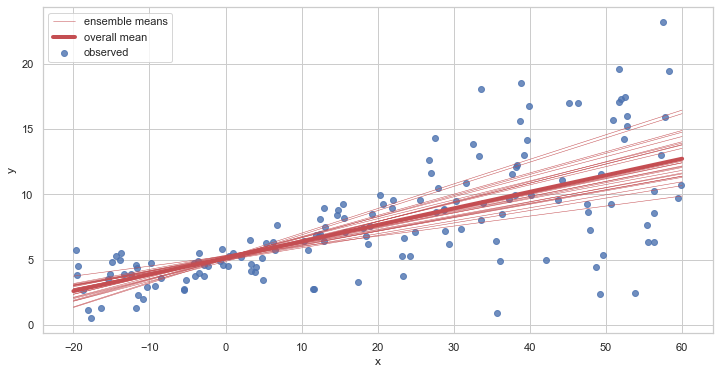

In [29]:
#@title Figure 3: Epistemic Uncertainty
plt.figure(figsize=(12, 6))

yhats = [model(x_tst) for _ in range(100)] #采样100次，得到100个不同的预测集
avgm = np.zeros_like(x_tst[..., 0]) #建立0向量
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  if i < 25: # 绘制出前 25 个样本的均值
    plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=0.5)
  avgm += m #绘制出采样100次的均值
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

sns.regplot(x='x',y='y',data=tra_data,label='observed',fit_reg=False)# 绘制训练点
plt.legend()
plt.savefig('./fig/fig3.png')


### Case 4: Aleatoric & Epistemic Uncertainty

In [30]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 0.12405791  2.86202474  5.20626703  4.02868799 -3.50152756 -1.17452178
 -2.33213363 -0.0101522 ]
[0.12859061 2.80615161 5.18291749 3.90694737]


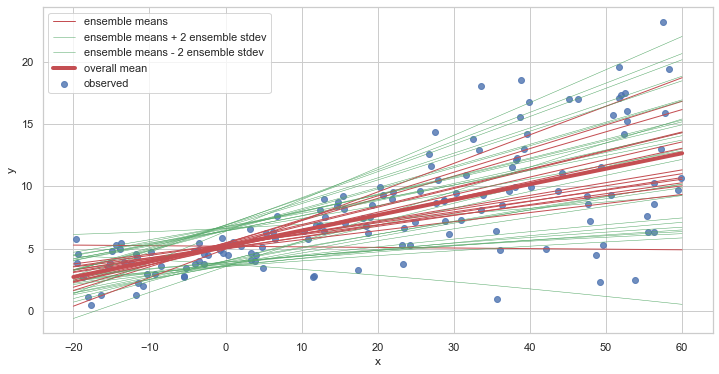

In [31]:
#@title Figure 4: Both Aleatoric & Epistemic Uncertainty
plt.figure(figsize=(12, 6))

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  if i < 15:
    plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
    plt.plot(x_tst, m + 2 * s, 'g', linewidth=0.5, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
    plt.plot(x_tst, m - 2 * s, 'g', linewidth=0.5, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
  avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)


sns.regplot(x='x',y='y',data=tra_data,label='observed',fit_reg=False)# 绘制训练点
plt.legend()
plt.savefig('./fig/fig4.png')

### Case 5: Functional Uncertainty

In [32]:
#@title Custom PSD Kernel
class RBFKernelFn(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(RBFKernelFn, self).__init__(**kwargs)
    dtype = kwargs.get('dtype', None)

    self._amplitude = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='amplitude')
    
    self._length_scale = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='length_scale')

  def call(self, x):
    # Never called -- this is just a layer so it can hold variables
    # in a way Keras understands.
    return x

  @property
  def kernel(self):
    return tfp.math.psd_kernels.ExponentiatedQuadratic(
      amplitude=tf.nn.softplus(0.1 * self._amplitude),
      length_scale=tf.nn.softplus(5. * self._length_scale)
    )

In [33]:
# For numeric stability, set the default floating-point dtype to float64
tf.keras.backend.set_floatx('float64')

# Build model.
num_inducing_points = 40
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[1]),
    tf.keras.layers.Dense(1, kernel_initializer='ones', use_bias=False),
    tfp.layers.VariationalGaussianProcess(
        num_inducing_points=num_inducing_points,
        kernel_provider=RBFKernelFn(),
        event_shape=[1],
        inducing_index_points_initializer=tf.constant_initializer(
            np.linspace(*x_range, num=num_inducing_points,
                        dtype=x.dtype)[..., np.newaxis]),
        unconstrained_observation_noise_variance_initializer=(
            tf.constant_initializer(np.array(0.54).astype(x.dtype))),
    ),
])

# Do inference.
batch_size = 32
loss = lambda y, rv_y: rv_y.variational_loss(
    y, kl_weight=np.array(batch_size, x.dtype) / x.shape[0])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=loss)
model.fit(x, y, batch_size=batch_size, epochs=1000, verbose=False)

# Profit.
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

/var/folders/sd/8xsdwm8n70q6psc1047lgnb40000gn/T/ipykernel_80797/1709427333.py:7: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self._amplitude = self.add_variable(
/var/folders/sd/8xsdwm8n70q6psc1047lgnb40000gn/T/ipykernel_80797/1709427333.py:12: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self._length_scale = self.add_variable(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow_probability/python/distributions/gaussian_process.py:398: UserWarning: Unable to detect statically whether the number of index_points is 1. As a result, defaulting to treating the marginal GP at `index_points` as a multivariate Gaussian. This makes some methods, like `cdf` unavailable.
  warnings.warn(


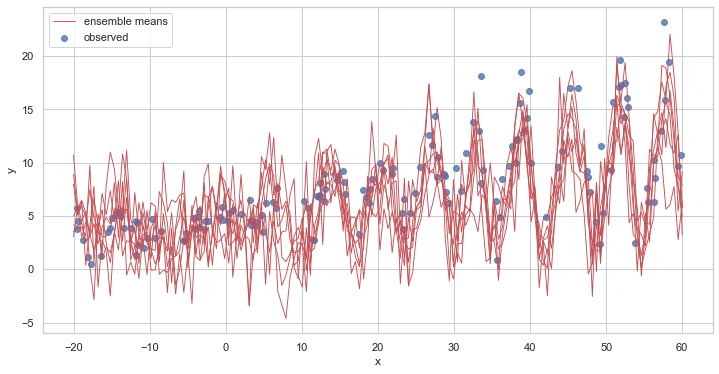

In [34]:
#@title Figure 5: Functional Uncertainty
plt.figure(figsize=(12, 6))

num_samples = 7
for i in range(num_samples):
  sample_ = yhat.sample().numpy()
  plt.plot(x_tst,
           sample_[..., 0].T,
           'r',
           linewidth=0.9,
           label='ensemble means' if i == 0 else None);

sns.regplot(x='x',y='y',data=tra_data,label='observed',fit_reg=False)# 绘制训练点
plt.legend()
plt.savefig('./fig/fig5.png')

### Case 6: Aleatoric & Epistemic Uncertainty 结合

在这个例子中，我们使用DenseFlipout层输出2维张量，并在最后的输出层变为分布的形式 (tfp.layers.DistributionLambda)
假设最后输出层满足简单高斯分布，DenseFlipout输出的2维张量中，一维用于拟合均值，一维用于拟合方差。

利用这个技巧，可以快速地同时捕获Aleatoric & Epistemic Uncertainty。
最后结果应该与 case 4 的类似。

使用 DenseFlipout层 能够让我们构建更深层、复杂的网络，在一般的CNN中，Dense层一般作为模型的输出。
利用DenseFlipout层来替换Dense，使用Convolution2DFlipout层代替Convolution2D层，
我们可以快速地构建贝叶斯卷积神经网络。

参考：
1. https://github.com/tensorchiefs/dl_book/blob/master/chapter_08/nb_ch08_03.ipynb

In [35]:
# 设置 DenseFlipout层 的权重和偏在的KL散度
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) # / (x.shape[0] * 1.0) #可除以batch size以减少此值
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) # / (x.shape[0] * 1.0)

#=== 2 维输出， 一个用于拟合分布的均值， 另一个用于拟合方差 ---- 
normal_sp = lambda t: tfd.Normal(loc=t[...,0],scale=1e-3 + tf.math.softplus(0.01 * t[...,1]))

def BNN_mdoel():
  inputs = tf.keras.layers.Input(shape=(1,))
  x = tfp.layers.DenseFlipout(2,kernel_divergence_fn=kernel_divergence_fn,
                              bias_divergence_fn=bias_divergence_fn)(inputs)
  dist = tfp.layers.DistributionLambda(normal_sp)(x)
  model = tf.keras.Model(inputs=inputs, outputs=dist)
  return model

model = BNN_mdoel()
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),loss=negloglik,metrics='mae') 
model.fit(x, y, epochs=1000, verbose=False,validation_data=val_data, )
# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


[0.13373742 1.62656293]
[-3.2743477  -0.02646462]
[ 5.17166999 27.06857018]


输出结果与 case 4 类似

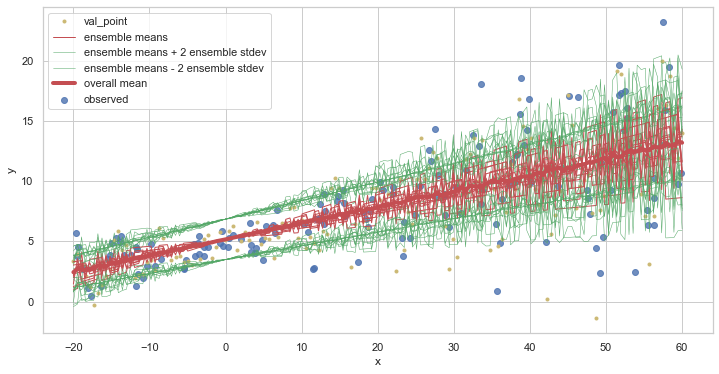

In [36]:
#@title Figure 6: Both Aleatoric & Epistemic Uncertainty
plt.figure(figsize=(12, 6))
plt.plot(x_tst, y_tst, 'y.', label='val_point') #评估点

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  if i < 15:
    plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
    plt.plot(x_tst, m + 2 * s, 'g', linewidth=0.5, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
    plt.plot(x_tst, m - 2 * s, 'g', linewidth=0.5, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
  avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

sns.regplot(x='x',y='y',data=tra_data,label='observed',fit_reg=False)# 绘制训练点
plt.legend()
plt.savefig('./fig/fig6.png',dpi=300)

